# **Display ILSVRC dataset and sample augmentations**

## **Navigation**


- [**1. Augmentation set #1**](#1.-Augmentation-set-#1)
- [**2. Augmentation set #2**](#2.-Augmentation-set-#2)
- [**3. Shapley augmentation scheme in action**](#3.-Shapley-augmentation-scheme-in-action)

## Basic imports and initialization

$\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#1.-Alexnet)

- [Setting up templates, limiting the hardware resources, importing packages](#Setting-up-templates,-limiting-the-hardware-resources,-importing-packages)
- [Initializing common variables](#Initializing-common-variables)
- [Configuring experiments and generating corresponding sh-files](#Configuring-experiments-and-generating-corresponding-sh-files)

### Limiting the hardware resources

$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Initializing-common-variables)

To provide easy access to modules stored in the ```../src/``` directory, we use the following workaround:

In [3]:
import sys
sys.path.append('../src/')

Next, we limit the hardware usage by setting the configuration dictionaries, maximum number of threads:

In [4]:
# set limitations on hardware
# fill on the template's config
import hardware_setup

mkl_num_threads = 4
hardware_setup.mkl_set_num_threads(num_threads=mkl_num_threads)

[mkl]: set up num_threads=4/4


### Importing necessary packages

Then we import all necessary packages:

In [91]:
import os
import functools

import torchvision
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import image_transforms.cropped_rotation
import image_transforms.erase
import image_transforms.crop_resize
import image_transforms.local_blur
import image_transforms.roll
import image_transforms.plot
import image_transforms.pre_post_processing

import preparation.shapley_scheme

import data_loader.imagenet

import torch_utils

import sensitivity_analysis.augmentation_setting

### Initializing common variables

In [93]:
preprocess_image = image_transforms.pre_post_processing._alexnet_pre_processing_functions
preprocess_image

Compose(
    Resize(size=256, interpolation=bilinear)
    CenterCrop(size=(224, 224))
    ToTensor()
)

In [6]:
normalizing_transform = torchvision.transforms.Lambda(lambda x: torch_utils.img_normalize(x, unit=True))

In [94]:
data_dirname = '../data/'
imagenet_subdirname = 'imagenet'
data_path = os.path.join(data_dirname, imagenet_subdirname)

ilsvrc_dataset = data_loader.imagenet.CustomImageNet(
    data_path,
    split='train',
    transform=preprocess_image,
    target_transform=None,
)

n_samples = 10

In [95]:
#ind = 377293 # bear
#ind = 373935 # tiger 1
#ind = 373818 # tiger 2
#ind = 373642 # tiger 3
ind = 187601 # pelippers
#ind = 189071 # penguins

image, label = ilsvrc_dataset[ind]

## 1. Augmentation set #1

$\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#2.-Augmentation-set-#2)

- [1.1 Erasing transform](#1.1-Erasing-transform)
- [1.2 Sharpness (constant)](#1.2-Sharpness-(constant))
- [1.3 Rolling transform](#1.3-Rolling-transform)
- [1.4 Grayscaling](#1.4-Grayscaling)
- [1.5 Gaussian blurring](#1.5-Gaussian-blurring)
- [1.6 Composed transformations](#1.6-Composed-transformations)


### 1.1 Erasing transform

$\quad$[[Back to section]](#1.-Augmentation-set-#1)$\quad$[[Next subsect.$\to$]](#1.2-Sharpness-(constant))

Erasing


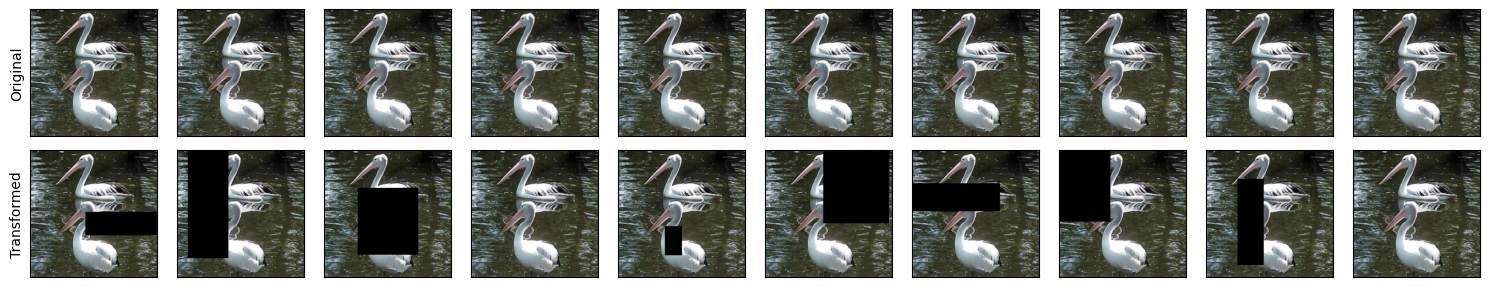

In [96]:
# erase rectangular part of image ## scale=(0.02, 0.33), ratio=(0.3, 3.3)

erasing_transform = image_transforms.erase.RandomErase(
    icoef_h_offset=sensitivity_analysis.augmentation_setting._erase_params_dict['icoef_h_offset'],
    icoef_w_offset=sensitivity_analysis.augmentation_setting._erase_params_dict['icoef_w_offset'],
    scale_bounds=sensitivity_analysis.augmentation_setting._erase_params_dict['scale_bounds'],
    log_ratio_bounds=sensitivity_analysis.augmentation_setting._erase_params_dict['log_ratio_bounds'],
    random_seed=0
)

print('Erasing')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            erasing_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 1.2 Sharpness (constant)

[[$\leftarrow$Prev.subsect.]](#1.1-Erasing-transform)$\quad$[[Back to section]](#1.-Augmentation-set-#1)$\quad$[[Next subsect.$\to$]](#1.3-Rolling-transform)

Sharpness const


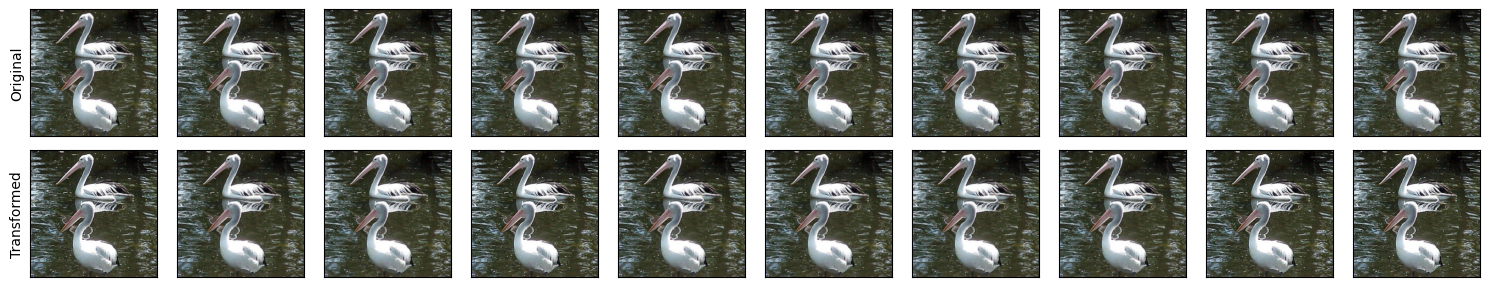

In [97]:
# adjust sharpness # 1.5, p=0.5

sharpness_transform = torchvision.transforms.RandomApply(
    [
        torchvision.transforms.Lambda(
                lambda img, sharpness_factor=1.5: (
                    torchvision.transforms.functional.adjust_sharpness(
                        img, sharpness_factor
                    )
                )
        )
    ], p=0.5
)

print('Sharpness const')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            sharpness_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 1.3 Rolling transform

[[$\leftarrow$Prev.subsect.]](#1.2-Sharpness-(constant))$\quad$[[Back to section]](#1.-Augmentation-set-#1)$\quad$[[Next subsect.$\to$]](#1.4-Grayscaling)


Rolling


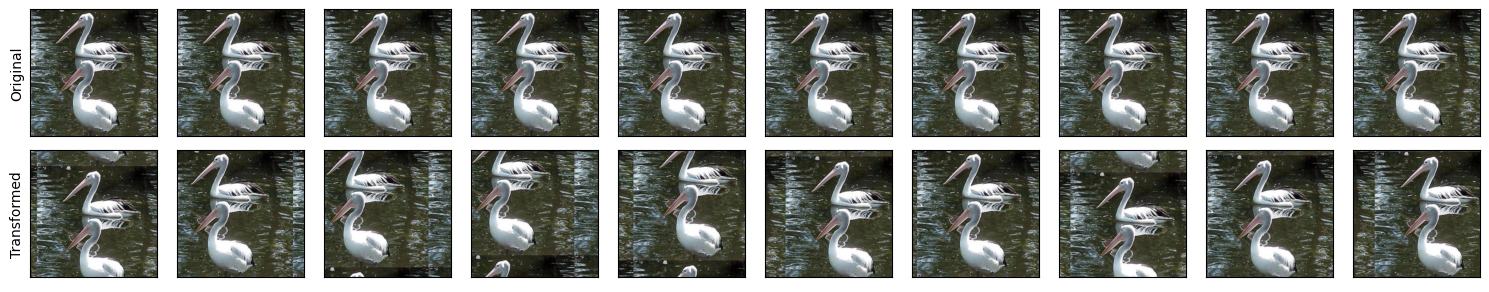

In [98]:
# roll image
channels, height, width = image.shape
icoef_h_offset = sensitivity_analysis.augmentation_setting._roll_params_dict['icoef_h_offset']
icoef_w_offset = sensitivity_analysis.augmentation_setting._roll_params_dict['icoef_w_offset']

roll_h_offset = height // icoef_h_offset
roll_w_offset = width // icoef_w_offset
    
roll_y_bounds = (-roll_h_offset, roll_h_offset)
roll_x_bounds = (-roll_w_offset, roll_w_offset)
    
rolling_transform = image_transforms.roll.RandomRoll2d(
    h=roll_y_bounds, w=roll_x_bounds
)

print('Rolling')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            rolling_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 1.4 Grayscaling

[[$\leftarrow$Prev.subsect.]](#1.3-Rolling-transform)$\quad$[[Back to section]](#1.-Augmentation-set-#1)$\quad$[[Next subsect.$\to$]](#1.5-Gaussian-blurring)


Grayscaling


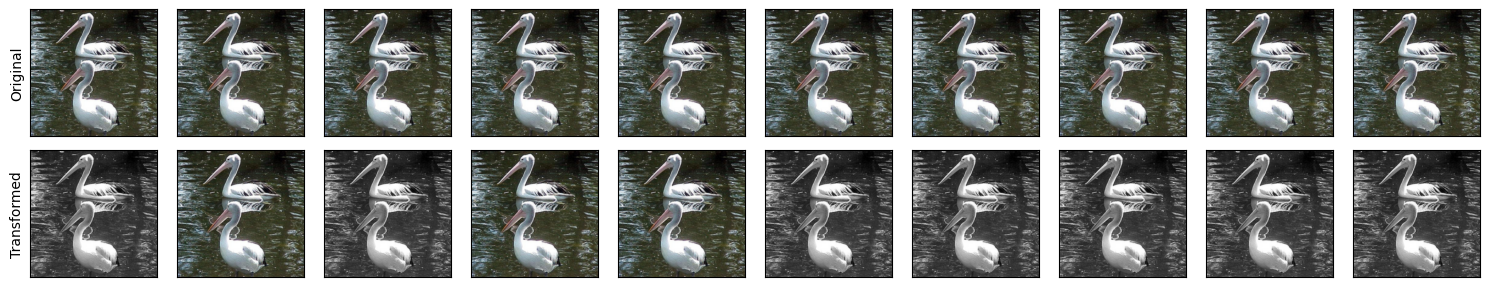

In [99]:
# grayscale
grayscale_transform = torchvision.transforms.RandomApply(
    [
        torchvision.transforms.Lambda(
            lambda img, num_output_channels=3: (
                torchvision.transforms.functional.rgb_to_grayscale(
                    img, num_output_channels
                )
            )
        )
    ], p=0.5
)


print('Grayscaling')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            grayscale_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 1.5 Gaussian blurring

[[$\leftarrow$Prev.subsect.]](#1.4-Grayscaling)$\quad$[[Back to section]](#1.-Augmentation-set-#1)$\quad$[[Next subsect.$\to$]](#1.6-Composed-transformations)

Gaussian blur


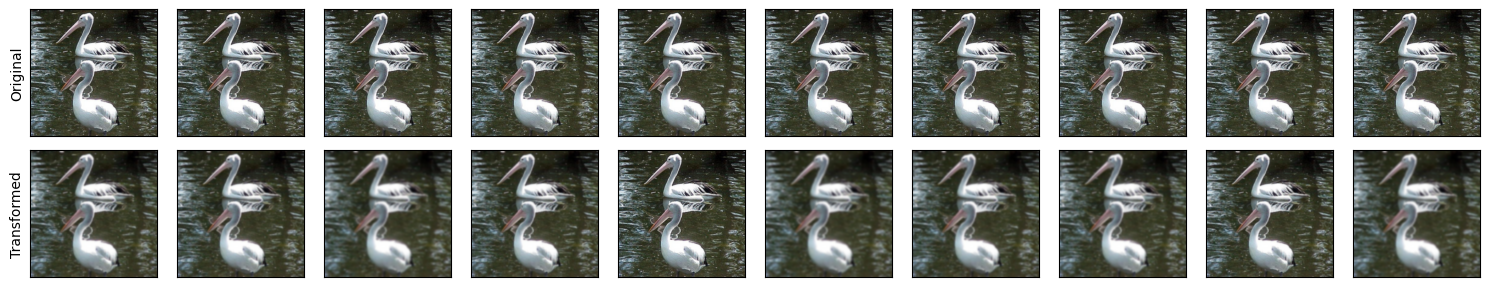

In [100]:
# global blurring (whole image)

gaussian_blur_transform = torchvision.transforms.GaussianBlur(
    kernel_size=(7, 7), # ! -> move
    sigma=sensitivity_analysis.augmentation_setting._gaussian_blur_params_dict['sigma_bounds']
)

print('Gaussian blur')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            gaussian_blur_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 1.6 Composed transformations

[[$\leftarrow$Prev.subsect.]](#1.5-Gaussian-blurring)$\quad$[[Back to section]](#1.-Augmentation-set-#1)

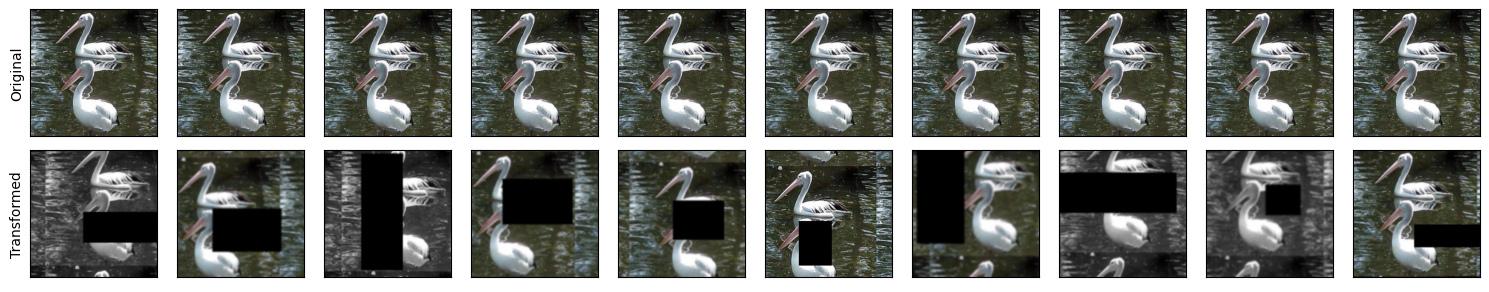

In [101]:
permute_seed = 0
transforms = [
    erasing_transform,
    sharpness_transform,
    rolling_transform,
    grayscale_transform,
    gaussian_blur_transform
]

rng = np.random.default_rng(permute_seed)
transforms = rng.permutation(transforms).tolist()

image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(transforms+[normalizing_transform]),
    image,
    n_samples
)

## 2. Augmentation set #2

[[$\leftarrow$ Prev. part]](#1.-Augmentation-set-#1) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#3.-Shapley-augmentation-scheme-in-action)

- [2.1 Brightness](#2.1-Brightness)
- [2.2 Contrast](#2.2-Contrast)
- [2.3 Saturation](#2.3-Saturation)
- [2.4 Hue](#2.4-Hue)
- [2.5 Horizontal flipping](#2.5-Horizontal-flipping)
- [2.6 Cropped rotation](#2.6-Cropped-rotation)
- [2.7 Elliptic local blurring](#2.7-Elliptic-local-blurring)
- [2.8 Composed transformations](#2.8-Composed-transformations)


### 2.1 Brightness

$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.2-Contrast)


Brightness


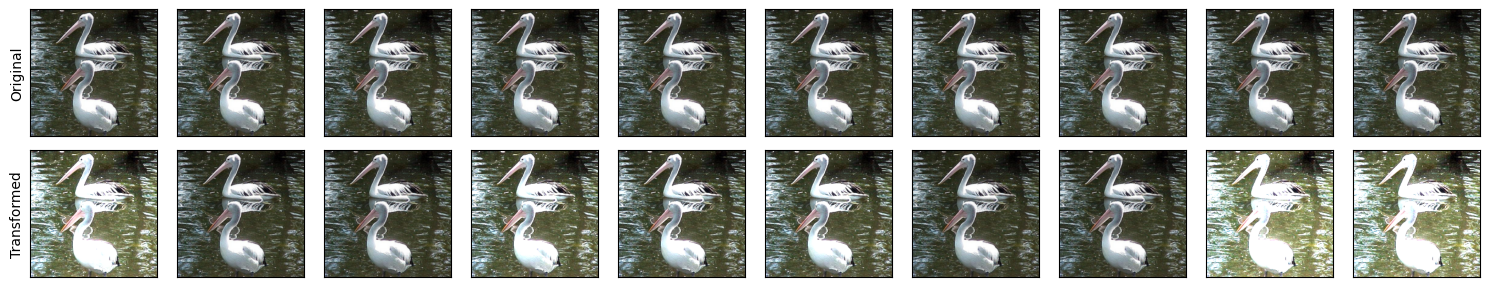

In [102]:
# uniformly sampled brightness adjusting

brightness_transform = torchvision.transforms.ColorJitter(
    brightness=sensitivity_analysis.augmentation_setting._brightness_params_dict['factor_bounds'],
    contrast=0,
    saturation=0,
    hue=0
)

print('Brightness')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            brightness_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)


### 2.2 Contrast

[[$\leftarrow$Prev.subsect.]](#2.1-Brightness)$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.3-Saturation)

Contrast


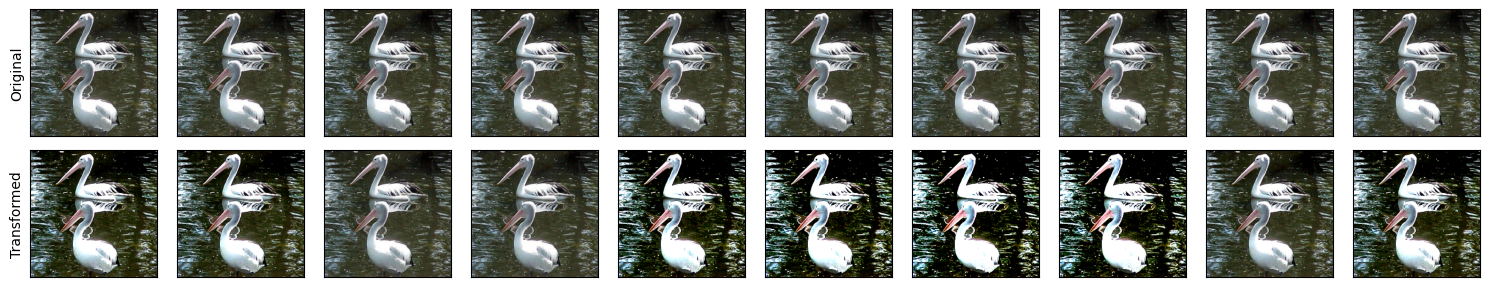

In [103]:
# uniformly sampled contrast adjusting

contrast_transform = torchvision.transforms.ColorJitter(
    brightness=0,
    contrast=sensitivity_analysis.augmentation_setting._contrast_params_dict['factor_bounds'],
    saturation=0,
    hue=0
)

print('Contrast')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            contrast_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 2.3 Saturation

[[$\leftarrow$Prev.subsect.]](#2.2-Contrast)$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.4-Hue)

Saturation


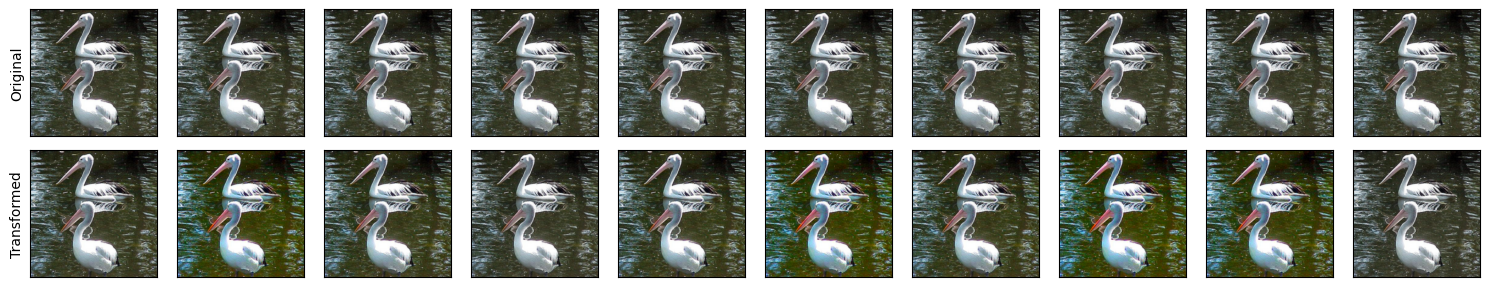

In [104]:
# uniformly sampled saturation adjusting

saturation_transform = torchvision.transforms.ColorJitter(
    brightness=0,
    contrast=0,
    saturation=sensitivity_analysis.augmentation_setting._saturation_params_dict['factor_bounds'],
    hue=0
)

print('Saturation')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            saturation_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 2.4 Hue

[[$\leftarrow$Prev.subsect.]](#2.3-Saturation)$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.5-Horizontal-flipping)

Hue


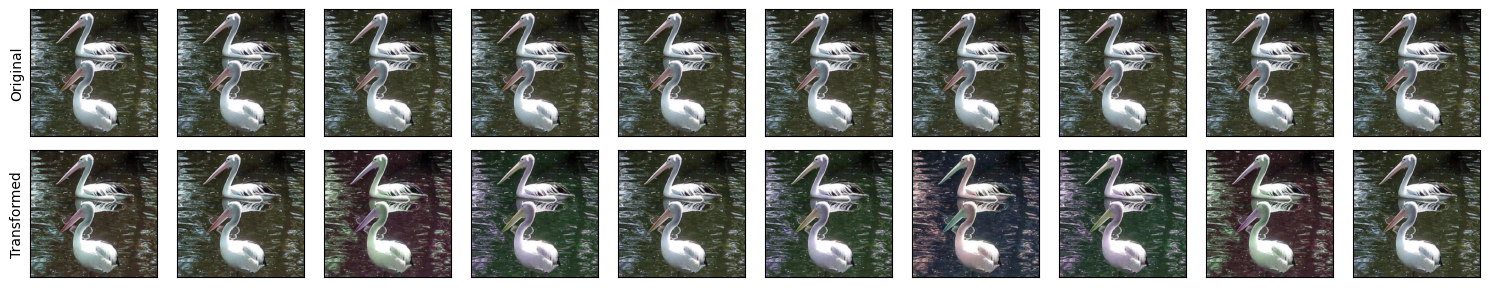

In [105]:
# # uniformly sampled hue adjusting

hue_transform = torchvision.transforms.ColorJitter(
    brightness=0,
    contrast=0,
    saturation=0,
    hue=sensitivity_analysis.augmentation_setting._hue_params_dict['factor_bounds'],
)

print('Hue')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            hue_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 2.5 Horizontal flipping

[[$\leftarrow$Prev.subsect.]](#2.4-Hue)$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.6-Cropped-rotation)

Horizontal flip


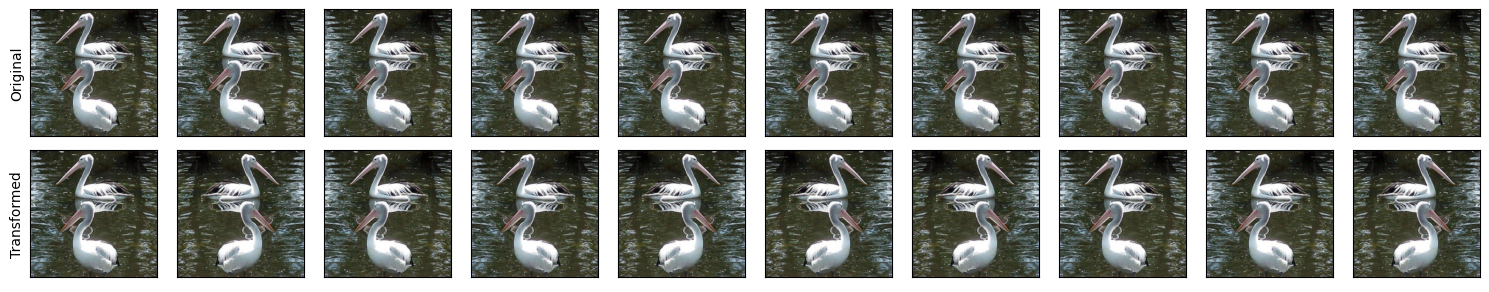

In [106]:
# random horizontal flipping (p=0.5)

random_horizontal_flip_transform = torchvision.transforms.RandomHorizontalFlip(
    p=0.5 # probability of transformation
)

print('Horizontal flip')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            random_horizontal_flip_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 2.6 Cropped rotation

[[$\leftarrow$Prev.subsect.]](#2.5-Horizontal-flipping)$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.7-Elliptic-local-blurring)

Cropped rotation


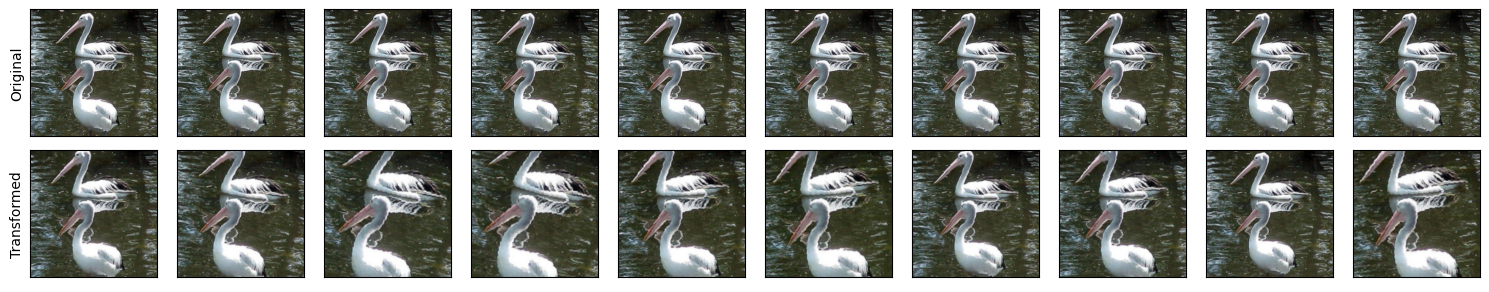

In [107]:
# rotation by uniformly sampled angle followed by cropping the padded areas

random_rotation_transform = image_transforms.cropped_rotation.CustomRandomRotation(
    degrees=sensitivity_analysis.augmentation_setting._rotation_params_dict['angle_bounds'],
    resample=False,
    expand=False,
    center=None
)

print('Cropped rotation')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            random_rotation_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)


### 2.7 Elliptic local blurring

[[$\leftarrow$Prev.subsect.]](#2.6-Cropped-rotation)$\quad$[[Back to section]](#2.-Augmentation-set-#2)$\quad$[[Next subsect.$\to$]](#2.8-Composed-transformations)

Elliptic local blur


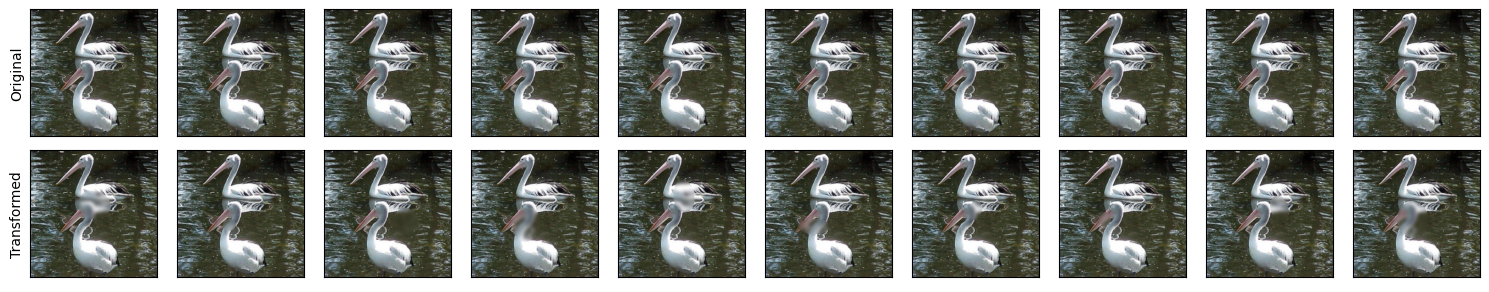

In [108]:
# random blurring an elliptic area within the given image

random_elliptic_local_blur_transform = image_transforms.local_blur.RandomEllipticLocalBlur(
    a=sensitivity_analysis.augmentation_setting._elb_params_dict['a_bounds'],
    b=sensitivity_analysis.augmentation_setting._elb_params_dict['b_bounds'],
    shift_x=sensitivity_analysis.augmentation_setting._elb_params_dict['shift_x_bounds'],
    shift_y=sensitivity_analysis.augmentation_setting._elb_params_dict['shift_y_bounds'],
    angle=sensitivity_analysis.augmentation_setting._elb_params_dict['angle_bounds'],
    sigma=3. # !!
)

print('Elliptic local blur')
image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(
        [
            random_elliptic_local_blur_transform,
            normalizing_transform # to [0, 1]
        ]
    ), image, n_samples
)

### 2.8 Composed transformations

[[$\leftarrow$Prev.subsect.]](#2.7-Elliptic-local-blurring)$\quad$[[Back to section]](#2.-Augmentation-set-#2)

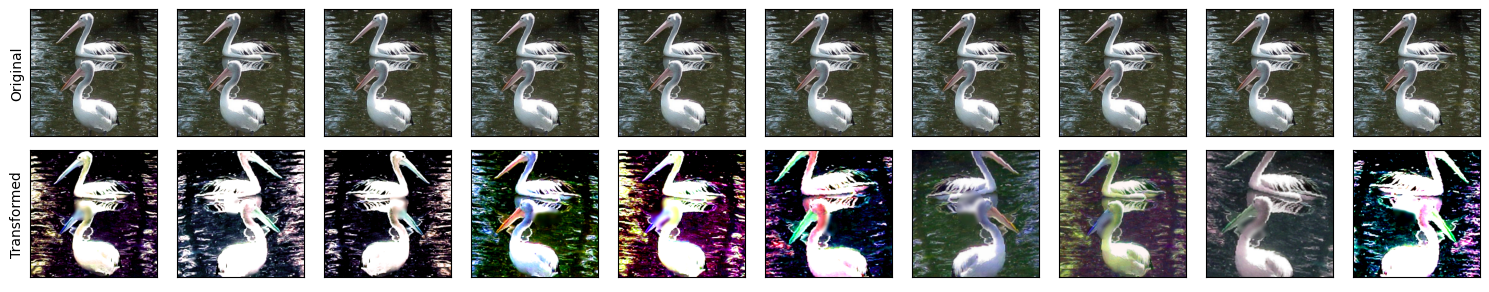

In [112]:
permute_seed = 9804
transforms = [
    brightness_transform,
    contrast_transform,
    saturation_transform,
    hue_transform,
    random_horizontal_flip_transform,
    random_rotation_transform,
    random_elliptic_local_blur_transform
]

rng = np.random.default_rng(permute_seed)
transforms = rng.permutation(transforms).tolist()

image_transforms.plot.visually_inspect_image_transform(
    torchvision.transforms.Compose(transforms+[normalizing_transform]),
    image,
    n_samples
)

## 3. Shapley augmentation scheme in action

[[$\leftarrow$ Prev. part]](#2.-Augmentation-set-#2) $\qquad$ [[Back to top]](#Navigation)

- [3.1 Initialize sampler parameters](#3.1-Initialize-sampler-parameters)
- [3.2 Initialize display parameters](#3.2-Initialize-display-parameters)
- [3.3 Trace sampling process](#3.3-Trace-sampling-process)

### 3.1 Initialize sampler parameters

$\quad$[[Back to section]](#3.-Shapley-augmentation-scheme-in-action)$\quad$[[Next subsect.$\to$]](#3.2-Initialize-display-parameters)

In [137]:
dataset_loader_func = data_loader.imagenet.CustomImageNet

desired_image_height = 224
desired_image_width = 224

Nouter_samples = 5
Ninner_samples = 5

train_size = 0.75
n_samples_per_class = 732

variables_permutation_seed = 178
problem_sampler_seed = 987
class_sampler_seed = 908
class_selector_seed = 479
permutation_sampler_seed = 212
partition_sampler_seed = 889
splitting_random_seed = 345
equating_random_state = 886

pre_processing_functions = preprocess_image
dataset_loader_func_params_dict = {}
image_shape = (3, desired_image_height, desired_image_width)

use_permutation_variable = True
use_partition_variable = True

build_dataset = functools.partial(
    preparation.shapley_scheme.CustomDatasetShapley,
    dataset_loader_func=dataset_loader_func,
    dataset_loader_func_params_dict=dataset_loader_func_params_dict,
    data_dirname=data_path,
    #augmentation_set_number,
    image_shape=image_shape,
    Nouter_samples=Nouter_samples,
    Ninner_samples=Ninner_samples,
    activations_path=None,
    batch_size=None,
    train_size=train_size,
    valid_size=None,
    n_samples_per_class=n_samples_per_class,
    n_samples_all=None,
    split_classwise=True,
    pre_processing_functions=pre_processing_functions,
    use_permutation_variable=use_permutation_variable,
    use_partition_variable=use_partition_variable,
    variables_permutation_seed=variables_permutation_seed,
    problem_sampler_seed=problem_sampler_seed,
    class_sampler_seed=class_sampler_seed,
    class_selector_seed=class_selector_seed,
    permutation_sampler_seed=permutation_sampler_seed,
    partition_sampler_seed=partition_sampler_seed,
    splitting_random_seed=splitting_random_seed,
    equating_random_state=equating_random_state,
    p_test_partition=0.5,
    labels_attr_name='targets',
    dataset_init_split='train',
    augset1_p=0.5,
    augset2_p=0.5,
)

### 3.2 Initialize display parameters

[[$\leftarrow$Prev.subsect.]](#3.1-Initialize-sampler-parameters)$\quad$[[Back to section]](#3.-Shapley-augmentation-scheme-in-action)$\quad$[[Next subsect.$\to$]](#3.3-Trace-sampling-process)

In [135]:
wait_interval = 1

n_cols = 5
figsize = (25, 10)

### 3.3 Trace sampling process

[[$\leftarrow$Prev.subsect.]](#3.2-Initialize-display-parameters)$\quad$[[Back to section]](#3.-Shapley-augmentation-scheme-in-action)$\quad$

- [3.3.1 Augmentaion set 1](#3.3.1-Augmentaion-set-1)
- [3.3.2 Augmentaion set 2](#3.3.2-Augmentaion-set-2)

#### 3.3.1 Augmentaion set 1

[[Back to subsection]](#3.3-Trace-sampling-process)

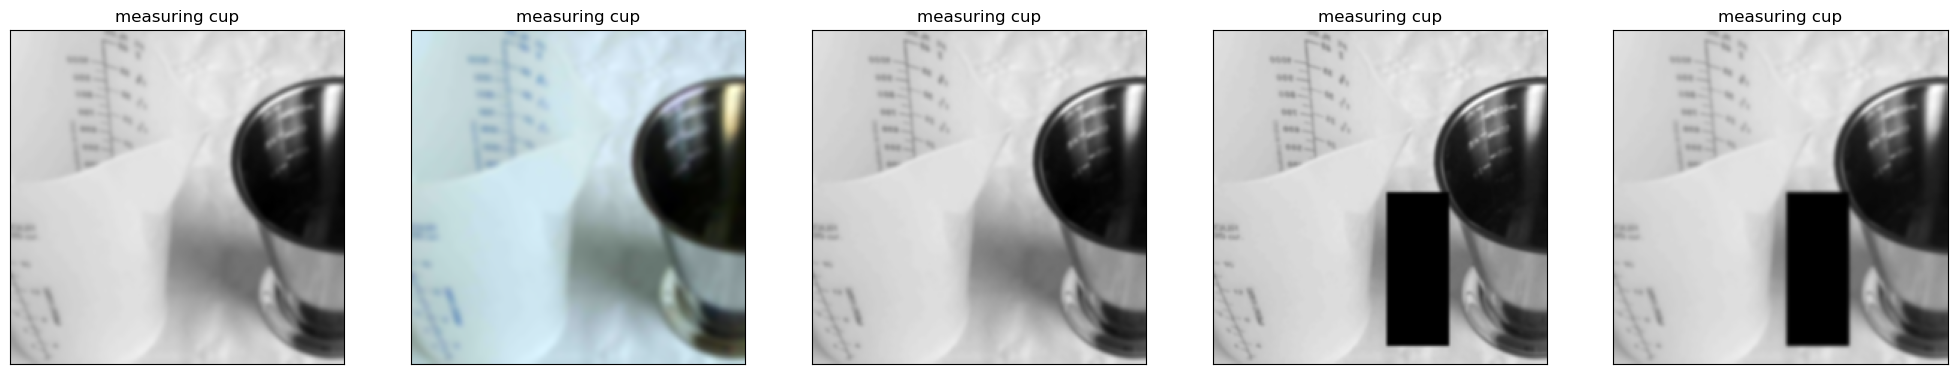

In [139]:
augmentation_set_number = 1
train_dataset = build_dataset(augmentation_set_number=augmentation_set_number)
image_transforms.plot.dynamic_multi_plot(
    train_dataset, wait_interval, n_cols, figsize, normalizing_transform
)

#### 3.3.2 Augmentaion set 2

[[Back to subsection]](#3.3-Trace-sampling-process)

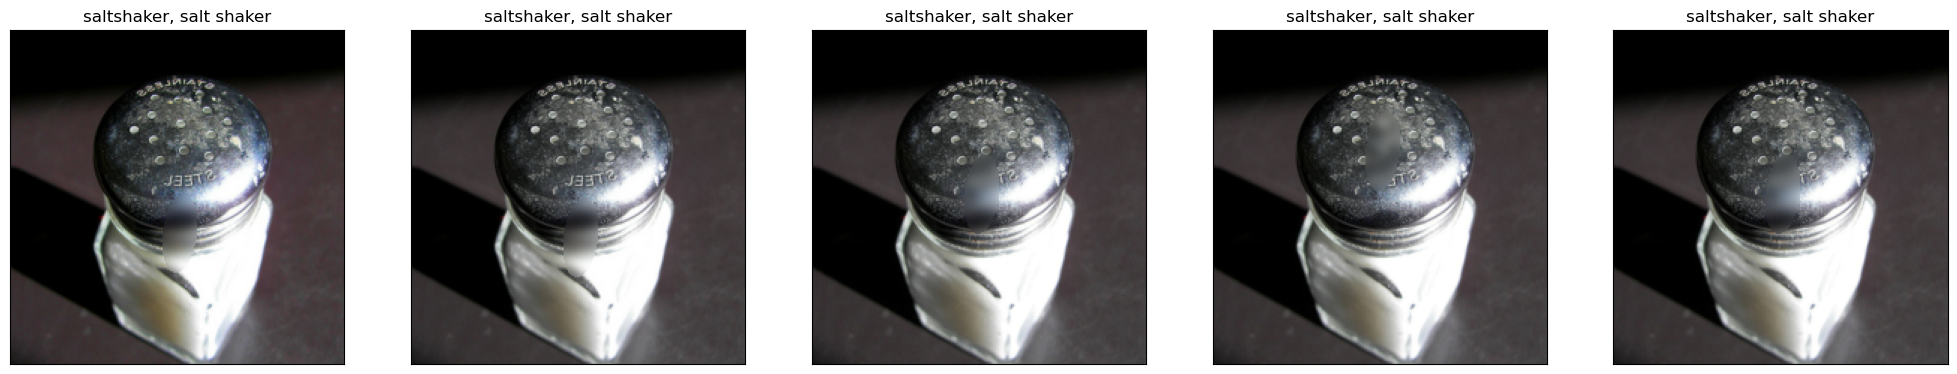

In [141]:
augmentation_set_number = 2
train_dataset = build_dataset(augmentation_set_number=augmentation_set_number)
image_transforms.plot.dynamic_multi_plot(
    train_dataset, wait_interval, n_cols, figsize, normalizing_transform
)